In [1]:
import copy
import time
from glob import glob

import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import optim, nn
import torch.optim.lr_scheduler as lr_scheduler
import torchvision
from torchvision import models, transforms
from torch.utils.data import RandomSampler
from torch.utils.data.sampler import SubsetRandomSampler

In [2]:
from torchvision.datasets import ImageFolder
import utils

In [3]:
import os

In [4]:
pokemons = sorted(os.listdir('data/Pokemon'))

In [5]:
len(pokemons)

150

In [6]:
from sklearn.datasets import load_files
import pandas as pd

def load_dataset(path):
    data = load_files(path, load_content=False)
    labels = data.target_names
    df = pd.merge(pd.DataFrame(data.target, columns=['target']), pd.DataFrame(data.target_names, columns=['pokemon']),
                          how='left', left_on='target', right_index=True)
    df = pd.concat([df, pd.DataFrame(data.filenames, columns=['filename']),
                    #pd.DataFrame(data.data, columns=['data'])
                   ], axis=1, sort=False)
    return df

df = load_dataset('data/Pokemon')
pokemons = np.sort(df['pokemon'].unique())

In [7]:
resnet50 = models.resnet50(pretrained=True)

In [8]:
mean_nums = [0.485, 0.456, 0.406]
std_nums = [0.229, 0.224, 0.225]

transform = {'train': transforms.Compose([
  transforms.RandomResizedCrop(size=64),
  transforms.RandomRotation(degrees=15),
  transforms.RandomHorizontalFlip(),
  transforms.ToTensor(),
  transforms.Normalize(mean_nums, std_nums)

]), 'val': transforms.Compose([
  transforms.Resize(size=64),
  #transforms.CenterCrop(size=224),
  transforms.ToTensor(),
  transforms.Normalize(mean_nums, std_nums)

]), 'test': transforms.Compose([
  transforms.Resize(size=64),
  transforms.CenterCrop(size=64),
  transforms.ToTensor(),
  transforms.Normalize(mean_nums, std_nums)
]),
}

In [9]:
valid_size = 0.2

train_data = ImageFolder('data/Pokemon', transform=transform['train'])
test_data = ImageFolder('data/Pokemon', transform=transform['test'])
num_train = len(train_data)
indices = list(range(num_train))
split = int(np.floor(valid_size * num_train))
np.random.shuffle(indices)
train_idx, test_idx = indices[split:], indices[:split]
train_sampler = SubsetRandomSampler(train_idx)
test_sampler = SubsetRandomSampler(test_idx)
train_loader = torch.utils.data.DataLoader(train_data,
               sampler=train_sampler, batch_size=4)
test_loader = torch.utils.data.DataLoader(test_data,
               sampler=test_sampler, batch_size=4)

In [10]:
import matplotlib.pyplot as plt
from torchvision import datasets, transforms

for i in range(3):
    batch_x, batch_y = next(iter(train_loader))
    print(np.shape(batch_x), batch_y)

torch.Size([4, 3, 64, 64]) tensor([  6,  59, 105, 135])
torch.Size([4, 3, 64, 64]) tensor([127,  75,  19, 130])
torch.Size([4, 3, 64, 64]) tensor([107,  64,  12, 105])


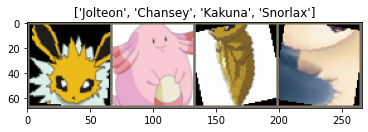

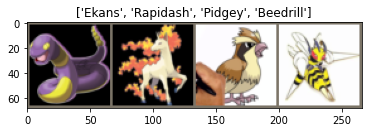

In [11]:
utils.imshow_data_loader(train_loader, std_nums, mean_nums, pokemons)
utils.imshow_data_loader(test_loader, std_nums, mean_nums, pokemons)

In [12]:
data_loaders = {
    'train': train_loader,
    'val': test_loader
}
dataset_sizes = {
    'train': len(train_loader),
    'val': len(test_loader)
}

In [13]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in data_loaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [14]:

def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(data_loaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}, ground truth: {}'
                             .format(pokemons[preds[j]],
                                     pokemons[labels[j]]))
                utils.imshow_tensor(inputs.cpu().data[j], std_nums, mean_nums)

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

### ConvNet as fixed feature extractor

We freeze the network and one layer with 2 outputs for our 2 classes.

In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device('cpu')

model_conv = models.resnet50(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, len(pokemons))

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [16]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=1)

Epoch 0/0
----------
train Loss: 19.2241 Acc: 0.1686
val Loss: 24.4979 Acc: 0.2258

Training complete in 5m 18s
Best val Acc: 0.225806


In [17]:
PATH = './pokemon_classifier.pth'
torch.save(model_conv, PATH)

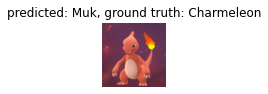

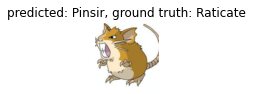

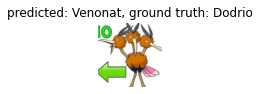

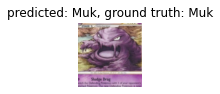

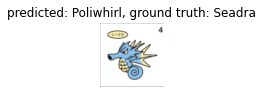

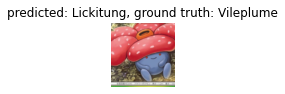

In [18]:
visualize_model(model_conv, num_images=6)

plt.ioff()
plt.show()